# Instacart Basket Dataset Exploration

This notebook is to explore the Instacart basket dataset obtained from Kaggle. We assess how fit the dataset is for our project and observe details of the dataset.

In [2]:
%pip install pandas numpy matplotlib

Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

We first load the dataset.

In [4]:
orders_df = pd.read_csv('../instacart_data/orders.csv')
prior_products_df = pd.read_csv('../instacart_data/order_products__prior.csv')
train_products_df = pd.read_csv('../instacart_data/order_products__train.csv')

print(orders_df)
print(prior_products_df)
print(train_products_df)

         order_id  user_id eval_set  order_number  order_dow  \
0         2539329        1    prior             1          2   
1         2398795        1    prior             2          3   
2          473747        1    prior             3          3   
3         2254736        1    prior             4          4   
4          431534        1    prior             5          4   
...           ...      ...      ...           ...        ...   
3421078   2266710   206209    prior            10          5   
3421079   1854736   206209    prior            11          4   
3421080    626363   206209    prior            12          1   
3421081   2977660   206209    prior            13          1   
3421082    272231   206209    train            14          6   

         order_hour_of_day  days_since_prior_order  
0                        8                     NaN  
1                        7                    15.0  
2                       12                    21.0  
3                  

We observe that the dataset consists of orders, what was ordered, and how long since the last order. This goes against what we initially thought the dataset was. We thought it was the date of order, but it shows up as days since last order. This indicates that this dataset was meant to observe repeat orders and bought together items. We will still see if we can work with it.

We will for the sake of the project assume that orders by users are placed a week after each other. We then merge the datasets and apply this assumption. We also aggregate by product id and by week.

In [5]:
if not os.path.exists('historical_orders.csv'):
    orders_df = pd.read_csv('../instacart_data/orders.csv')
    prior_products_df = pd.read_csv('../instacart_data/order_products__prior.csv')
    train_products_df = pd.read_csv('../instacart_data/order_products__train.csv')

    order_products_df = pd.concat([prior_products_df, train_products_df])
    merged_df = pd.merge(orders_df, order_products_df, on='order_id')

    start_date = datetime(2021, 1, 1)  # Assuming the orders start from January 1, 2021
    merged_df['order_date'] = merged_df.apply(lambda x: start_date + timedelta(days=(x['order_number'] - 1) * 7), axis=1)

    merged_df['year'] = merged_df['order_date'].dt.year
    merged_df['week'] = merged_df['order_date'].dt.isocalendar().week

    historical_orders_df = merged_df.groupby(['year', 'week', 'product_id']).size().reset_index(name='quantity')

    historical_orders_df.to_csv('historical_orders.csv', index=False)
else:
    historical_orders_df = pd.read_csv('historical_orders.csv')

historical_orders_df

,year,week,product_id,quantity
0,2021,1,1,103
1,2021,1,2,5
2,2021,1,3,19
3,2021,1,4,33
4,2021,1,7,3
...,...,...,...,...
1808613,2022,47,49610,3
1808614,2022,47,49615,1
1808615,2022,47,49621,2
1808616,2022,47,49667,1


This looks better, the data might work. There are a lot of entries however, with over 49000 products. This level of granularity is too high for our use case. While this would make sense when in deployment in an actual store, it would be difficult to make work for our use case.

We can then save as a numpy array for later analysis. We take the dimensions (year, week, productID) where the values are the number sold.

In [6]:
if not os.path.exists('historical_orders.npy'):
    years = historical_orders_df['year'].unique()
    weeks = historical_orders_df['week'].unique()
    product_ids = range(1, 49689)  # All possible product IDs from 1 to 49688
    multi_index = pd.MultiIndex.from_product([years, weeks, product_ids], names=['year', 'week', 'product_id'])

    historical_orders_array = historical_orders_df.set_index(['year', 'week', 'product_id']).reindex(multi_index, fill_value=0).values.reshape(-1, len(weeks), len(product_ids))

    np.save('historical_orders.npy', historical_orders_array)
else:
    historical_orders_array = np.load('historical_orders.npy')

We then explore the data by plotting ten most sold products over the weeks.

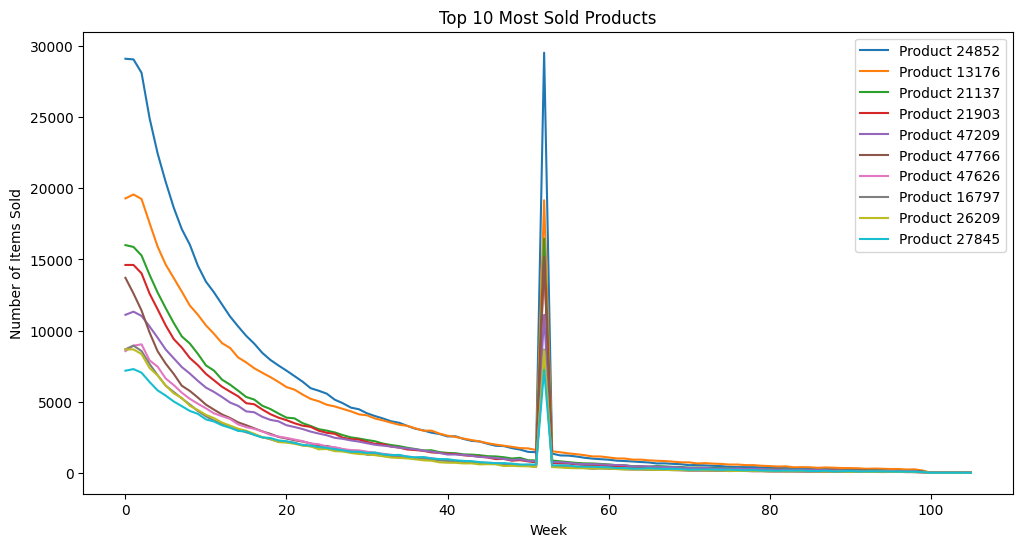

In [7]:
reshaped_array = historical_orders_array.reshape(-1, historical_orders_array.shape[-1])
total_quantity_sold = reshaped_array.sum(axis=0)
top_10_products = total_quantity_sold.argsort()[-10:][::-1]

plt.figure(figsize=(12, 6))
for product_id in top_10_products:
    product_data = reshaped_array[:, product_id]
    plt.plot(range(len(product_data)), product_data, label=f"Product {product_id + 1}")
plt.xlabel("Week")
plt.ylabel("Number of Items Sold")
plt.title("Top 10 Most Sold Products")
plt.legend()
plt.show()

We find that this is not at all accurate to reality. Sales are biased towards the beginning of each year and fall down from there. We need to find a different dataset.